# Gerekli Kütüphanelerin Kurulumu

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Fonksiyonlar

In [49]:
def check_data_types(df):
    data_types = df.dtypes
    print("Veri Tipleri:\n", data_types)
    return data_types

In [50]:
# Zaman Damgası Formatını Kontrol Etme Fonksiyonu
def check_timestamp_format(df):
    print("TIME_STAMP veri tipi:", df['TIME_STAMP'].dtype)

In [51]:
# Düplikasyonları Kontrol ve Giderme Fonksiyonları
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f'Tekrarlanan satır sayısı: {duplicates}')
    return duplicates

def remove_duplicates(df):
    df = df.drop_duplicates()
    return df

In [52]:
# Z-Score Yöntemi
def detect_anomalies_zscore(df, column, threshold=10):
    z_scores = stats.zscore(df[column])
    abs_z_scores = np.abs(z_scores)
    df[f'ANOMALY_ZSCORE_{column}'] = abs_z_scores > threshold
    return df

In [53]:
# Isolation Forest Yöntemi
def detect_anomalies_isolation_forest(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Dönüşüm ekleniyor
    df = handle_missing_values(df)  # Eksik değerleri doldurma tekrar uygulanıyor
    model = IsolationForest(n_estimators=120, contamination=0.01)  # %1 oranında anomali varsayıyoruz
    df[f'ANOMALY_IF_{column}'] = model.fit_predict(df[[column]])
    df[f'ANOMALY_IF_{column}'] = df[f'ANOMALY_IF_{column}'] == -1
    return df

In [54]:
# Local Outlier Factor Yöntemi
def detect_anomalies_lof(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Dönüşüm ekleniyor
    df = handle_missing_values(df)  # Eksik değerleri doldurma tekrar uygulanıyor
    model = LocalOutlierFactor(n_neighbors=30, contamination=0.01)  # %1 oranında anomali varsayıyoruz (Bilmediğimiz için)
    df[f'ANOMALY_LOF_{column}'] = model.fit_predict(df[[column]])
    df[f'ANOMALY_LOF_{column}'] = df[f'ANOMALY_LOF_{column}'] == -1
    return df

In [55]:
# Veriyi Yükleme ve Zenginleştirme
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP'])
    df['DAY_OF_WEEK'] = df['TIME_STAMP'].dt.dayofweek
    df['HOUR'] = df['TIME_STAMP'].dt.hour
    df['MINUTE'] = df['TIME_STAMP'].dt.minute
    df = handle_missing_values(df)
    return df

In [56]:
# Anomali sonuçlarını karşılaştırma
def compare_anomalies(df, column):
    anomalies_zscore = df[f'ANOMALY_ZSCORE_{column}'].sum()
    anomalies_if = df[f'ANOMALY_IF_{column}'].sum()
    anomalies_lof = df[f'ANOMALY_LOF_{column}'].sum()
    print(f'Z-Score ile tespit edilen anomaliler: {anomalies_zscore}')
    print(f'Isolation Forest ile tespit edilen anomaliler: {anomalies_if}')
    print(f'LOF ile tespit edilen anomaliler: {anomalies_lof}')
    
    # Ortak anomalileri bulma
    df['ANOMALY_COMMON'] = df[[f'ANOMALY_ZSCORE_{column}', f'ANOMALY_IF_{column}', f'ANOMALY_LOF_{column}']].all(axis=1)
    common_anomalies = df['ANOMALY_COMMON'].sum()
    print(f'Ortak anomaliler: {common_anomalies}')

In [57]:
# Anomalileri görselleştirme
def plot_time_series_with_anomalies_v2(df, column):
    plt.figure(figsize=(14, 7))
    
    # Zaman serisi çizimi
    plt.plot(df['TIME_STAMP'], df[column], label=column, color='blue')
    
    # Anomalilerin işaretlenmesi
    anomalies_if = df[df[f'ANOMALY_IF_{column}'] == True]
    anomalies_lof = df[df[f'ANOMALY_LOF_{column}'] == True]
    anomalies_common = anomalies_if[anomalies_if.index.isin(anomalies_lof.index)]
    
    plt.scatter(anomalies_if['TIME_STAMP'], anomalies_if[column], color='red', label='IF Anomalies', s=10)
    plt.scatter(anomalies_lof['TIME_STAMP'], anomalies_lof[column], color='orange', label='LOF Anomalies', s=10)
    plt.scatter(anomalies_common['TIME_STAMP'], anomalies_common[column], color='green', label='Common Anomalies', s=20)
    
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Time Series with Anomalies for {column}')
    plt.show()

In [64]:
processed_data['UPLOAD'].describe()

count    35429.000000
mean       482.140941
std        267.923237
min         57.749000
25%        264.408000
50%        475.553000
75%        668.965000
max       1670.995000
Name: UPLOAD, dtype: float64

In [1]:
processed_data['DOWNLOAD'].describe()

NameError: name 'processed_data' is not defined

# Veri Görselleştirme

Z-Score ile tespit edilen anomaliler: 139
Isolation Forest ile tespit edilen anomaliler: 352
LOF ile tespit edilen anomaliler: 355
Ortak anomaliler: 56
Z-Score ile tespit edilen anomaliler: 138
Isolation Forest ile tespit edilen anomaliler: 355
LOF ile tespit edilen anomaliler: 355
Ortak anomaliler: 39


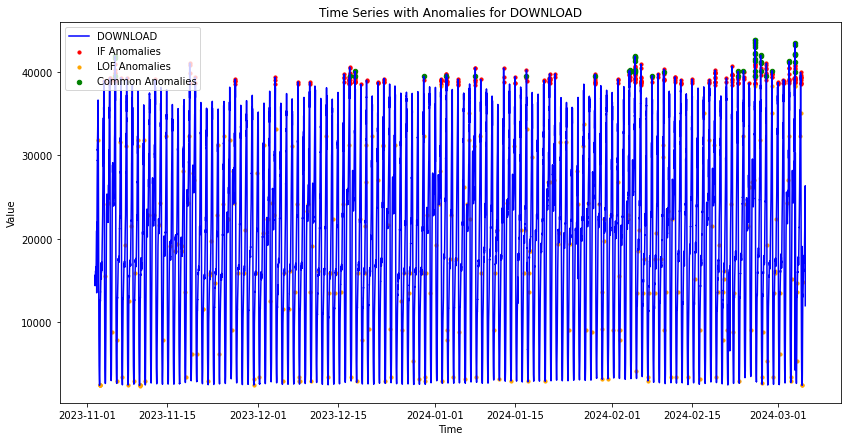

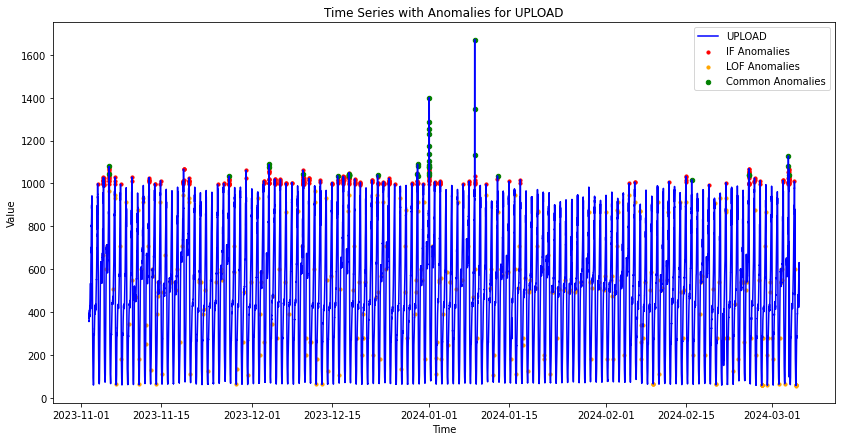

In [59]:
# Veriyi yükle ve zenginleştir
file_path = 'C:/Users/erend/Desktop/Innova - Hackathon/Veri Seti/hackathon 2024-Yapay Zeka.xlsx'
processed_data = preprocess_data(file_path)

# Anomali tespiti algoritmalarını uygula ('DOWNLOAD İÇİN')
processed_data = detect_anomalies_zscore(processed_data, 'DOWNLOAD', threshold=2)
processed_data = detect_anomalies_isolation_forest(processed_data, 'DOWNLOAD')
processed_data = detect_anomalies_lof(processed_data, 'DOWNLOAD')

# Anomali tespiti algoritmalarını uygula ('UPLOAD İÇİN')
processed_data = detect_anomalies_zscore(processed_data, 'UPLOAD', threshold=2)
processed_data = detect_anomalies_isolation_forest(processed_data, 'UPLOAD')
processed_data = detect_anomalies_lof(processed_data, 'UPLOAD')

# Anomalileri karşılaştır
compare_anomalies(processed_data, 'DOWNLOAD')
compare_anomalies(processed_data, 'UPLOAD')



# Anomalileri görselleştir
plot_time_series_with_anomalies_v2(processed_data, 'DOWNLOAD')
plot_time_series_with_anomalies_v2(processed_data, 'UPLOAD')



# DOWNLOAD İÇİN

In [60]:
# Isolation Forest tarafından tespit edilen anomaliler
anomalies_if = processed_data[processed_data[f'ANOMALY_IF_DOWNLOAD'] == True]

# LOF tarafından tespit edilen anomaliler
anomalies_lof = processed_data[processed_data[f'ANOMALY_LOF_DOWNLOAD'] == True]

# Ortak anomalileri belirleme (ikisinin de tespit ettiği)
anomalies_common_if_lof = anomalies_if[anomalies_if.index.isin(anomalies_lof.index)]

# Anomalileri inceleme
print("Isolation Forest Anomalies:\n", anomalies_if.head())
print("LOF Anomalies:\n", anomalies_lof.head())
print("Common Anomalies between IF and LOF:\n", anomalies_common_if_lof.head())

print(f'Isolation Forest ile tespit edilen toplam anomali sayısı: {len(anomalies_if)}')
print(f'LOF ile tespit edilen toplam anomali sayısı: {len(anomalies_lof)}')
print(f'IF ve LOF tarafından ortak tespit edilen anomali sayısı: {len(anomalies_common_if_lof)}')

Isolation Forest Anomalies:
              TIME_STAMP           SERVER_NAME   DOWNLOAD   UPLOAD  \
228 2024-03-04 23:10:00  10.0.901.xx Server 1  39386.021  969.410   
229 2024-03-04 23:05:00  10.0.901.xx Server 1  38620.166  956.490   
230 2024-03-04 23:00:00  10.0.901.xx Server 1  38750.499  961.372   
231 2024-03-04 22:55:00  10.0.901.xx Server 1  39630.653  977.985   
232 2024-03-04 22:50:00  10.0.901.xx Server 1  39432.158  981.907   

     DAY_OF_WEEK  HOUR  MINUTE  ANOMALY_ZSCORE_DOWNLOAD  ANOMALY_IF_DOWNLOAD  \
228            0    23      10                    False                 True   
229            0    23       5                    False                 True   
230            0    23       0                    False                 True   
231            0    22      55                     True                 True   
232            0    22      50                    False                 True   

     ANOMALY_LOF_DOWNLOAD  ANOMALY_ZSCORE_UPLOAD  ANOMALY_IF_UPLOAD  \
228 

# UPLOAD İÇİN

In [61]:
# Isolation Forest tarafından tespit edilen anomaliler (UPLOAD)
anomalies_if_upload = processed_data[processed_data['ANOMALY_IF_UPLOAD'] == True]

# LOF tarafından tespit edilen anomaliler (UPLOAD)
anomalies_lof_upload = processed_data[processed_data['ANOMALY_LOF_UPLOAD'] == True]

# Ortak anomalileri belirleme (ikisinin de tespit ettiği) (UPLOAD)
anomalies_common_if_lof_upload = anomalies_if_upload[anomalies_if_upload.index.isin(anomalies_lof_upload.index)]

# Anomali sayıları (UPLOAD)
print(f'Isolation Forest ile tespit edilen toplam anomali sayısı (UPLOAD): {len(anomalies_if_upload)}')
print(f'LOF ile tespit edilen toplam anomali sayısı (UPLOAD): {len(anomalies_lof_upload)}')
print(f'IF ve LOF tarafından ortak tespit edilen anomali sayısı (UPLOAD): {len(anomalies_common_if_lof_upload)}')

Isolation Forest ile tespit edilen toplam anomali sayısı (UPLOAD): 355
LOF ile tespit edilen toplam anomali sayısı (UPLOAD): 355
IF ve LOF tarafından ortak tespit edilen anomali sayısı (UPLOAD): 40


# Ortak Bulunan Anomaliler

In [62]:
anomalies_common_if_lof_upload

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD,DAY_OF_WEEK,HOUR,MINUTE,ANOMALY_ZSCORE_DOWNLOAD,ANOMALY_IF_DOWNLOAD,ANOMALY_LOF_DOWNLOAD,ANOMALY_ZSCORE_UPLOAD,ANOMALY_IF_UPLOAD,ANOMALY_LOF_UPLOAD,ANOMALY_COMMON
522,2024-03-03 22:10:00,10.0.901.xx Server 1,40744.152,1041.102,6,22,10,True,True,False,True,True,True,True
534,2024-03-03 21:10:00,10.0.901.xx Server 1,39251.108,1128.645,6,21,10,False,True,False,True,True,True,True
535,2024-03-03 21:05:00,10.0.901.xx Server 1,39188.768,1082.368,6,21,5,False,True,False,True,True,True,True
2506,2024-02-25 23:05:00,10.0.901.xx Server 1,43270.615,1041.058,6,23,5,True,True,True,True,True,True,True
2511,2024-02-25 22:40:00,10.0.901.xx Server 1,42223.049,1041.338,6,22,40,True,True,True,True,True,True,True
5354,2024-02-15 22:45:00,10.0.901.xx Server 1,37039.191,1016.744,3,22,45,False,False,False,False,True,True,False
15042,2024-01-12 22:55:00,10.0.901.xx Server 1,40509.724,1035.362,4,22,55,True,True,False,True,True,True,True
16179,2024-01-08 23:10:00,10.0.901.xx Server 1,35358.328,1132.929,0,23,10,False,False,False,True,True,True,True
16180,2024-01-08 23:05:00,10.0.901.xx Server 1,36689.371,1670.995,0,23,5,False,False,False,True,True,True,True
16181,2024-01-08 23:00:00,10.0.901.xx Server 1,37455.335,1348.520,0,23,0,False,False,False,True,True,True,True


# Anomali Kontrol

In [63]:
# Veri noktasını DataFrame olarak oluşturma
new_data = pd.DataFrame({
    'DOWNLOAD': [11927.017],
    'UPLOAD': [424.7]
})

# Modeli yükledik (bu örnekte varsayılan bir Isolation Forest modeli kullanılmıştır)
model = IsolationForest(n_estimators=120, contamination=0.01)
model.fit(processed_data[['DOWNLOAD', 'UPLOAD']])  # Eğitim için özellikler


# Veri noktası için anomali tespiti yapma
prediction = model.predict(new_data)
is_anomaly = prediction == -1

# Sonucu yazdırma
if is_anomaly:
    print("Verilen veri noktası bir anomali olarak tespit edilmiştir.")
else:
    print("Verilen veri noktası normal olarak tespit edilmiştir.")

Verilen veri noktası normal olarak tespit edilmiştir.
